In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = (Path().cwd().parents[0] / 'data').absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
df_imgs_path = data_dir / 'indirect'  /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)

# Generate scatter plot

In [5]:
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    df_ppi = df_ppi[df_ppi.Cyto!=0]
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [6]:
df_imgs

,Condition,FOV,Path
0,ctrl,FW1,y:\coskun-lab\Thomas\23_PLA_revision\data\indi...
1,o,FW1,y:\coskun-lab\Thomas\23_PLA_revision\data\indi...


In [12]:
# Read PPI
PPI_save_path = data_dir /'indirect' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Read masks 
masks_folder = data_dir /'indirect' / 'imgs' / 'masks_filtered'

In [13]:
df.PPI.unique()

array(['5 Pairs', 'cdc25c/p38'], dtype=object)

In [14]:
PPI_cycles = [['5 Pairs'], ['cdc25c/p38']]

In [15]:
df.columns = ['Cyto', 'row', 'column',  'PPI', 'Nuclei', 'Nuclei_Cell', 'Condition', 'FOV']


## Drug treated

In [25]:
# Get images
index = 1
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']

mask_path = masks_folder / f'Cell_{row.Condition}_{row.FOV}.tif'
mask = skimage.io.imread(mask_path)

Condition                                                    o
FOV                                                        FW1
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\indi...
Name: 1, dtype: object


In [26]:

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 1611,1325
x_max, y_max = 2107,1755

DAPI_ch = 0

In [27]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]
mask_id = np.unique(mask[y_min:y_max, x_min:x_max])
color = {i: 'white' for i in mask_id if i != 0}

colors = ['magenta']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='cyan', contrast_limits=[0,200])
    label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color, opacity=0.9)
    label.contour = 2
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j], opacity=0.9)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'indirect_O_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_48316\488586555.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'indirect_O_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48316\488586555.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'indirect_O_{i}.tif', removeBorders(screenshot))


## Control

In [35]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']


mask_path = masks_folder / f'Cell_{row.Condition}_{row.FOV}.tif'
mask = skimage.io.imread(mask_path)

Condition                                                 ctrl
FOV                                                        FW1
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\indi...
Name: 0, dtype: object


In [36]:
image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 1874,2385
x_max, y_max = 2418,2893

DAPI_ch = 0

In [37]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]
mask_id = np.unique(mask[y_min:y_max, x_min:x_max])
color = {i: 'white' for i in mask_id if i != 0}

colors = ['magenta']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='cyan', contrast_limits=[0,200])
    label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color, opacity=0.9)
    label.contour = 2
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j], opacity=0.9)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'indirect_ctrl_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_48316\1629320715.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'indirect_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48316\1629320715.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'indirect_ctrl_{i}.tif', removeBorders(screenshot))


# Quantification

In [5]:
# Read PPI
PPI_save_path =  data_dir / 'indirect' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei_Cell']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Nuclei', 'Count Nuclei']
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [6]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_clipboard()

In [7]:
# Filter out by maximum number of counts per cell
min_count = 0
max_count = 500

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

C:\Users\thu71\AppData\Local\Temp\ipykernel_881480\1507205534.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,1227.000000,1227.000000,1227.000000
mean,246.198044,106.938875,139.259169
std,102.454298,44.328564,74.714757
min,1.000000,0.000000,1.000000
25%,176.000000,81.000000,87.000000
50%,229.000000,103.000000,124.000000
75%,307.000000,131.000000,183.000000
max,599.000000,353.000000,414.000000


In [8]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel('data.xlsx')

## Comparison between condition

In [9]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [10]:
from statannotations.Annotator import Annotator
import seaborn as sns 

def plot(plotting, figsize=(7,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.3):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='full', loc='outside', show_test_name=False)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [11]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

df_all['Condition'] = df_all['Condition'].apply(lambda x: {'ctrl': 'Control', 'o': 'Treated'}.get(x, x))
df_all['Condition'].unique()

array(['Control', 'Treated'], dtype=object)

cdc25c/p38_Control vs. cdc25c/p38_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.293e-113 U_stat=3.286e+05
5 Pairs_Control vs. 5 Pairs_Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:9.331e-02 U_stat=1.778e+05


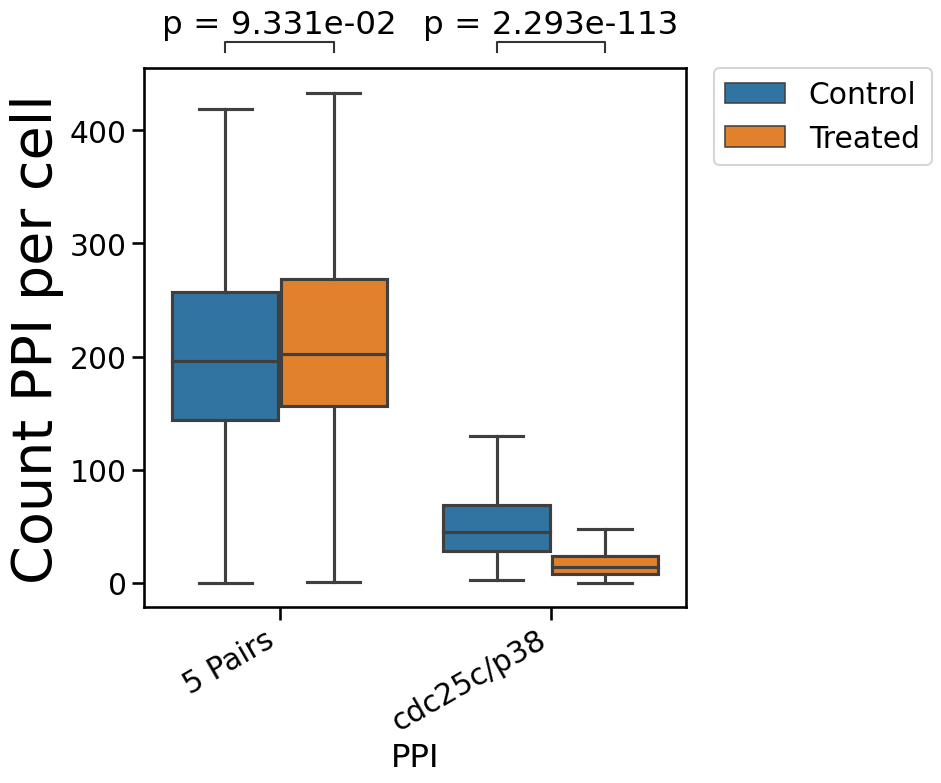

In [12]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

In [13]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

# Pixel intensity comparison

In [14]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [15]:
# Read PPI
PPI_save_path =  data_dir / 'indirect' / 'PPI' / 'expression'
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

df['Condition'] = df['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))
df = df[df.PPI == '5 Pairs']
df = df[df.Cyto != 0]

In [16]:
df.head()

,Cyto,x,y,Intensity,PPI,Condition,FOV
0,159,1113,4122,222,5 Pairs,Control,FW1
1,228,1444,4279,214,5 Pairs,Control,FW1
2,674,4565,5177,218,5 Pairs,Control,FW1
3,559,3954,3406,149,5 Pairs,Control,FW1
4,685,4593,5390,176,5 Pairs,Control,FW1


In [17]:
df_int = df.groupby(['Cyto', 'Condition'])['Intensity'].sum()
df_count = df.groupby(['Cyto', 'Condition'])['Intensity'].size()
df_final = df_int.div(df_count)
df_final = df_final.reset_index()
df_final.columns = ['Cyto', 'Condition','Average Intensity']

In [18]:
df_final

,Cyto,Condition,Average Intensity
0,28,Control,36.823009
1,29,Control,34.097222
2,30,Control,31.025641
3,32,o,21.765432
4,33,o,29.776699
...,...,...,...
1237,806,o,38.207469
1238,808,o,55.200000
1239,809,o,50.017986
1240,815,o,51.163366


In [19]:
df_final['Condition'] = df_final['Condition'].apply(lambda x: {'ctrl': 'Control', 'o': 'Treated'}.get(x, x))
df_final['Condition'].unique()

array(['Control', 'Treated'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Control vs. Treated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.626e-16 U_stat=1.415e+05


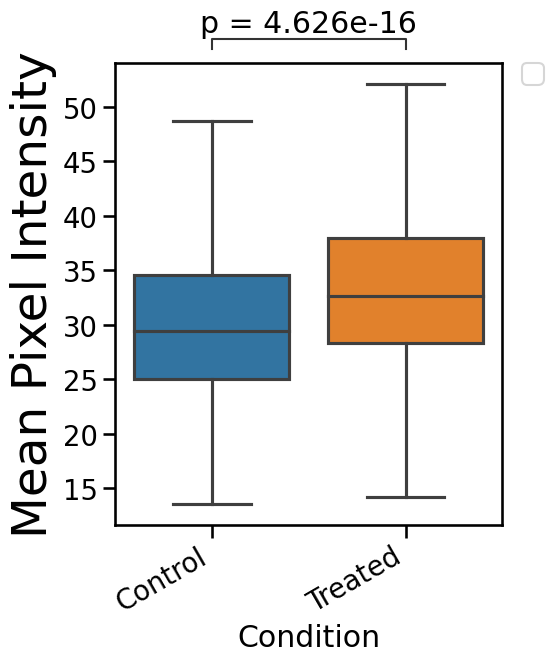

In [20]:
# Boxplot per cell
plotting = {
    "data": df_final,
    "x": "Condition",
    "y": "Average Intensity",
}

pairs = [('Control', 'Treated')]

with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(5,6))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney',  text_format='full', loc='outside', show_test_name=False)
    result = annot.apply_test().annotate()
    ax.set_ylabel('Mean Pixel Intensity', fontsize=35)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [22]:
plotting['data'].groupby([plotting['x']])[plotting['y']].describe().to_clipboard()